https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb

# Multi-head-attention
- Dot-Product Attention을 여러개 만들어 다양한 특징에 대한 어텐션을 볼 수 있게 한 방법
입력받은 query, key, value를 헤드 수 만큼 나누어 병렬적으로 계산

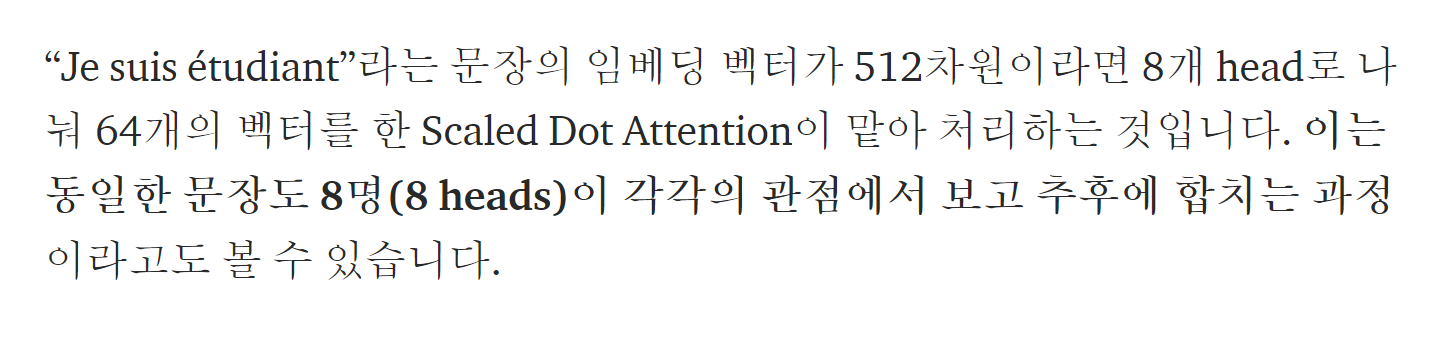

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize=tokenize_de,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)
TRG = Field(tokenize=tokenize_en,
           init_token = '<sos>',
           eos_token = '<eos>',
           lower = True,
           batch_first = True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device=device)

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

In [12]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        x = torch.matmul(self.dropout(attention), V)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        x = self.fc_o(x)     
        
        return x, attention

In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        output = self.fc_out(trg)
            
        return output, attention

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        _trg = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        return trg, attention

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

In [18]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,597 trainable parameters


In [20]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [21]:
model.apply(initialize_weights);

In [22]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:, :-1])
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            src = batch.src
            trg = batch.trg
            
            output, _ = model(src, trg[:, :-1])
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 39s
	Train Loss: 2.246 | Train PPL:   9.447
	 Val. Loss: 1.986 |  Val. PPL:   7.283
Epoch: 02 | Time: 0m 39s
	Train Loss: 1.890 | Train PPL:   6.617
	 Val. Loss: 1.809 |  Val. PPL:   6.103
Epoch: 03 | Time: 0m 40s
	Train Loss: 1.642 | Train PPL:   5.167
	 Val. Loss: 1.711 |  Val. PPL:   5.533
Epoch: 04 | Time: 0m 39s
	Train Loss: 1.453 | Train PPL:   4.276
	 Val. Loss: 1.649 |  Val. PPL:   5.200
Epoch: 05 | Time: 0m 39s
	Train Loss: 1.300 | Train PPL:   3.668
	 Val. Loss: 1.628 |  Val. PPL:   5.093
Epoch: 06 | Time: 0m 39s
	Train Loss: 1.176 | Train PPL:   3.240
	 Val. Loss: 1.614 |  Val. PPL:   5.021
Epoch: 07 | Time: 0m 40s
	Train Loss: 1.065 | Train PPL:   2.900
	 Val. Loss: 1.623 |  Val. PPL:   5.069
Epoch: 08 | Time: 0m 39s
	Train Loss: 0.972 | Train PPL:   2.642
	 Val. Loss: 1.636 |  Val. PPL:   5.136
Epoch: 09 | Time: 0m 39s
	Train Loss: 0.889 | Train PPL:   2.433
	 Val. Loss: 1.658 |  Val. PPL:   5.247
Epoch: 10 | Time: 0m 39s
	Train Loss: 0.815 | Train PPL

In [30]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.674 | Test PPL:   5.331 |
